# Предсказание банковских транзакций

**Описание задачи**<br/>
Одним из самых ценных источников информации о клиенте являются данные о банковских транзакциях.</br>
В этом соревновании участникам предлагается предсказать будущие траты клиента, используя информацию о совершенных тратах.</br>

**Полезная информация**</br>
Для понимания представленных данных будет полезна следующая <a href="https://www.banki.ru/wikibank/mcc-kod/">*статья*</a></br>

<a href="https://mcc-codes.ru/code">Описание MCC-кодов.</a></br>

**BaseLine**</br>
Для быстрого старта можно использовать решение, приведенное ниже:</br>
https://www.kaggle.com/prampampam/baseline-popular-transactions

**Формат решения задачи**</br>
Решение ожидаем в виде файла csv. Пример: submission_file.csv из <a href="https://www.kaggle.com/competitions/alfabank-campus/data">раздела Data.</a></br>

**Вопросы**</br>
https://www.kaggle.com/competitions/alfabank-campus/discussion/442418

**Метрика качества**</br>
<a href="https://habr.com/ru/companies/econtenta/articles/303458">**MAP@10**</a></br>

**Описание набора данных**




**File descriptions**</br>
1. df_train.csv — данные для обучения предиктиного алгоритма
2. df_test.csv — тестовый датасет
3. submission_file.csv — пример файла сабмита клиента

**Data fields** </br>
1. df_train.csv
   - data - история трат клиентов (последовательность mcc-кодов в хронологическом порядке);
   - target - последовательность будущих трат клиента.
3. df_test.csv
   - Id - идентификатор клиента;
   - история трат клиентов (последовательность mcc-кодов в хронологическом порядке). 
5. submission_file.scv
   - Id - идентификатор клиента;
   - Predicted - предсказание следующих 10 транзакций клиента.

## Подготовка и анализ

Общая концепция: 
1. Избавиться от выбросов
2. Определить количество значений у каждого id, построить ящик с усами, оставить только ниболее большое количество значений или то количество значений, соответствующее выборке с предсказаниями.
3. Обучить модель на данных
4. Предсказать значения для нескольких случаев(10)

Произведём загрузку данных, библиотек и их компонентов

In [1]:
import pandas as pd
from IPython.display import display 
import matplotlib.pyplot as plt

Определим функцию для загрузки файла

In [2]:
def download_file(name, sep=';'):
    try:
        data = pd.read_csv('data/' + name, index_col ='Id', sep=sep)
        return data
    except Exception as _:
        print('Загрузка файла вызвала ошибку\n', _)

Получим наборы данных для изучения

In [3]:
df_train = download_file('df_train.csv')
df_test = download_file('df_test.csv')
submission_baseline_2 = download_file('submission_baseline_2.csv', sep=',')

### Оценка наборов данных

Изучим данные

**df_train**

In [4]:
df_train.head(5)

,Data,Target
Id,,
0,"4814,4814,6010,6011,4814,6011,6011,4814,6011,6...","4814,4814,4814,4814,5411,4814,4814,4814,4814,4814"
1,"6011,6011,6011,6011,6011,6011,6011,4814,4814,4...","4814,6011,4814,6011,4814,4814,6011,4814,6011,4814"
2,"8021,6011,6011,6010,4829,4814,6011,6011,6011,6...","6011,6011,6010,4829,4829,6010,6011,6011,4814,6011"
3,"4814,6011,4814,4814,4814,6011,6011,5691,5691,5...","6011,6011,6010,6011,6011,4814,4814,6011,4814,4814"
4,"4814,4814,4814,4814,4814,4814,5946,4814,4814,6...","5499,6011,4814,4829,5200,5411,5499,5912,5411,5912"


In [5]:
df_train.loc[0, 'Data'][:20]

'4814,4814,6010,6011,'

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7033 entries, 0 to 7032
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    7033 non-null   object
 1   Target  7033 non-null   object
dtypes: object(2)
memory usage: 422.9+ KB


**df_test**

In [7]:
df_test.head(5)

,Data
Id,
0,"4814,4814,6011,6011,6010,6011,6011,4814,6011,4..."
1,"6010,6011,6010,5411,5411,5977,6011,6010,5411,6..."
2,"4814,6011,5251,6011,7832,5641,5814,4829,5311,6..."
3,"6011,4722,4722,4722,4814,6011,6011,4829,6011,6..."
4,"4814,4814,4814,6011,4814,4814,4814,4814,4814,4..."


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7033 entries, 0 to 7032
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    7033 non-null   object
dtypes: object(1)
memory usage: 109.9+ KB


Посмотрим на пример вывода

In [9]:
submission_baseline_2.head()

,Predicted
Id,
0,[6011 4814 6010 4829 5499 5541 5411 6011 6010 ...
1,[6011 6010 5411 6011 6010 4814 5411 4829 5499 ...
2,[6011 6010 5499 4814 5411 5814 4829 5812 6011 ...
3,[6011 4814 5964 5411 4829 5912 6010 6012 5814 ...
4,[4814 6011 6011 6010 4814 5411 4829 5499 5541 ...


In [10]:
submission_baseline_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7033 entries, 0 to 7032
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Predicted  7033 non-null   object
dtypes: object(1)
memory usage: 109.9+ KB


Посмотрим на предсказания. Изучим какое значение в среднем бывет.

In [11]:
len([int(el) for el in submission_baseline_2.loc[0, 'Predicted'][1:-1].split()])

17

In [12]:
how = submission_baseline_2['Predicted'].apply(lambda x: len([int(el) for el in x[1: -1].split()]))
how.describe()

count    7033.000000
mean       17.184416
std         2.866280
min        11.000000
25%        15.000000
50%        18.000000
75%        20.000000
max        20.000000
Name: Predicted, dtype: float64

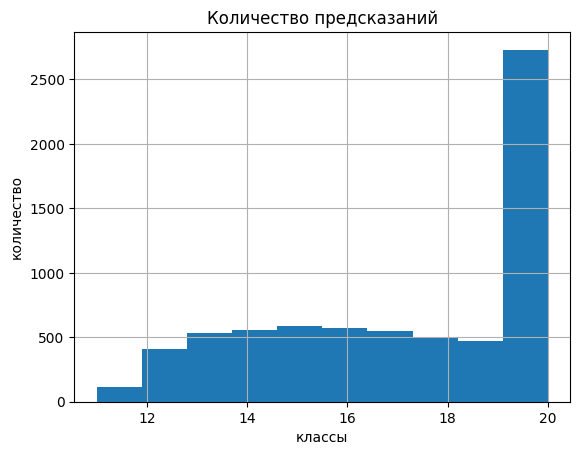

In [13]:
how.hist(range=(11, 20))
plt.title('Количество предсказаний')
plt.xlabel('классы')
plt.ylabel('количество');

### Вывод

* для `df_train` и `df_test` можно сделать заключение, что необходимо преобразовать данные из строчного формата в целочисленный;
* MCC коды напоминают токены в обработке текста, возможно это свойство получиться использовать;
* также, вероятно, что данные подойдут для обучения нейросетью. 


Приведение значений из строчного формата в чиловой

In [14]:
df_train['Data'] = df_train.Data.apply(lambda s: list(map(int, s.split(','))))
df_train['Target'] = df_train.Target.apply(lambda s: list(map(int, s.split(','))))
df_test['Data'] = df_test.Data.apply(lambda s: list(map(int, s.split(','))))

In [15]:
df_train.head(2)

,Data,Target
Id,,
0,"[4814, 4814, 6010, 6011, 4814, 6011, 6011, 481...","[4814, 4814, 4814, 4814, 5411, 4814, 4814, 481..."
1,"[6011, 6011, 6011, 6011, 6011, 6011, 6011, 481...","[4814, 6011, 4814, 6011, 4814, 4814, 6011, 481..."


In [16]:
df_test.head(2)

,Data
Id,
0,"[4814, 4814, 6011, 6011, 6010, 6011, 6011, 481..."
1,"[6010, 6011, 6010, 5411, 5411, 5977, 6011, 601..."


In [17]:
submission_baseline_2.head(2)

,Predicted
Id,
0,[6011 4814 6010 4829 5499 5541 5411 6011 6010 ...
1,[6011 6010 5411 6011 6010 4814 5411 4829 5499 ...


Изучим получившиеся наборы данных

In [18]:
df_train.head()

,Data,Target
Id,,
0,"[4814, 4814, 6010, 6011, 4814, 6011, 6011, 481...","[4814, 4814, 4814, 4814, 5411, 4814, 4814, 481..."
1,"[6011, 6011, 6011, 6011, 6011, 6011, 6011, 481...","[4814, 6011, 4814, 6011, 4814, 4814, 6011, 481..."
2,"[8021, 6011, 6011, 6010, 4829, 4814, 6011, 601...","[6011, 6011, 6010, 4829, 4829, 6010, 6011, 601..."
3,"[4814, 6011, 4814, 4814, 4814, 6011, 6011, 569...","[6011, 6011, 6010, 6011, 6011, 4814, 4814, 601..."
4,"[4814, 4814, 4814, 4814, 4814, 4814, 5946, 481...","[5499, 6011, 4814, 4829, 5200, 5411, 5499, 591..."


Определить количество значений у каждого id, построить ящик с усами, оставить только ниболее большое количество значений или то количество значений, соответствующее выборке с предсказаниями.

In [19]:
# d_train = {}
# for el in df_train.loc[0, 'Data']:
#     if el not in d_train.keys():
#         d_train[el] = 1
#     else:
#         d_train[el] += 1

# #d_train
# for key, val in d_train.items():
#     df_train.loc[:, key] = val
#     print(key, val)

In [20]:
def make_columns(row):
    d_train = {}
    for el in row['Data']:
        if el not in d_train.keys():
            d_train[el] = 1
        else:
            d_train[el] += 1

    
    # display(pd.DataFrame([d_train.values()], columns=d_train.keys()))
    new_data = pd.DataFrame([d_train.values()], columns=d_train.keys())
    
    # for key, val in d_train.items():
    #     row[key] = val
    
    # print(key, val)
    # print(row)
    # # row[2] = d_train.keys()
    
    return row#d_train.keys()
    

    

In [21]:
df_train.head(1).apply(make_columns, axis=1)

,Data,Target
Id,,
0,"[4814, 4814, 6010, 6011, 4814, 6011, 6011, 481...","[4814, 4814, 4814, 4814, 5411, 4814, 4814, 481..."


In [22]:
df_train.head()

,Data,Target
Id,,
0,"[4814, 4814, 6010, 6011, 4814, 6011, 6011, 481...","[4814, 4814, 4814, 4814, 5411, 4814, 4814, 481..."
1,"[6011, 6011, 6011, 6011, 6011, 6011, 6011, 481...","[4814, 6011, 4814, 6011, 4814, 4814, 6011, 481..."
2,"[8021, 6011, 6011, 6010, 4829, 4814, 6011, 601...","[6011, 6011, 6010, 4829, 4829, 6010, 6011, 601..."
3,"[4814, 6011, 4814, 4814, 4814, 6011, 6011, 569...","[6011, 6011, 6010, 6011, 6011, 4814, 4814, 601..."
4,"[4814, 4814, 4814, 4814, 4814, 4814, 5946, 481...","[5499, 6011, 4814, 4829, 5200, 5411, 5499, 591..."


In [23]:
for el in set(df_train.loc[0, 'Data']):
    print(df_train.loc[df_train['Data'] == el, 'Data'])

Series([], Name: Data, dtype: object)
Series([], Name: Data, dtype: object)
Series([], Name: Data, dtype: object)
Series([], Name: Data, dtype: object)
Series([], Name: Data, dtype: object)
Series([], Name: Data, dtype: object)


In [24]:
[i for i in range(len(df_train.loc[0, 'Data'])) if df_train.loc[0, 'Data'][i] == 4814]

[0,
 1,
 4,
 7,
 10,
 12,
 13,
 16,
 17,
 21,
 22,
 27,
 28,
 33,
 35,
 36,
 37,
 38,
 39,
 42,
 43,
 44,
 45,
 49,
 52,
 54,
 57,
 60,
 62,
 63,
 64,
 67,
 69,
 75,
 77,
 81,
 83,
 86,
 88,
 89,
 90,
 101,
 105,
 107,
 111,
 112,
 115,
 116,
 117,
 122,
 124,
 125,
 126,
 128,
 129,
 137,
 139,
 150,
 152,
 154,
 156,
 164,
 166,
 168,
 172,
 173,
 174,
 175,
 187,
 188,
 189,
 190,
 191,
 202,
 208,
 210,
 211,
 212,
 213,
 214,
 215]

In [25]:
df_train.loc[0, 'Data'][0]

4814

Определим функцию для отображения первичной информации

In [26]:
def first_info(name):
    display(name.head())
    display(name.info())

In [27]:
top10_codes = df_train['Data'].explode().value_counts().head(10)
top10_codes

Data
6011    700677
6010    490602
4814    473396
5411    472408
4829    307388
5499    164719
5541     68224
5912     65071
5331     61833
5812     52029
Name: count, dtype: int64

array([[<Axes: title={'center': 'Data'}>,
        <Axes: title={'center': 'count'}>]], dtype=object)

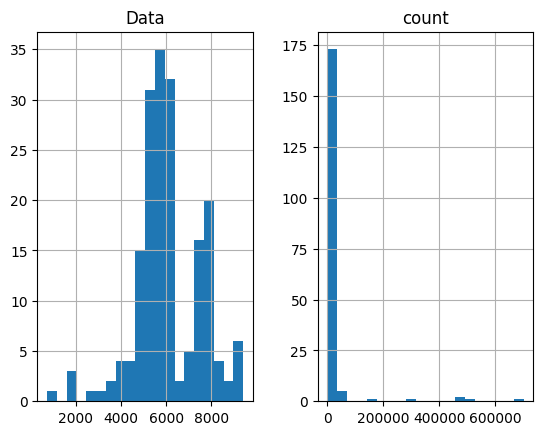

In [28]:
df_train['Data'].explode().value_counts().reset_index().hist(bins=20)

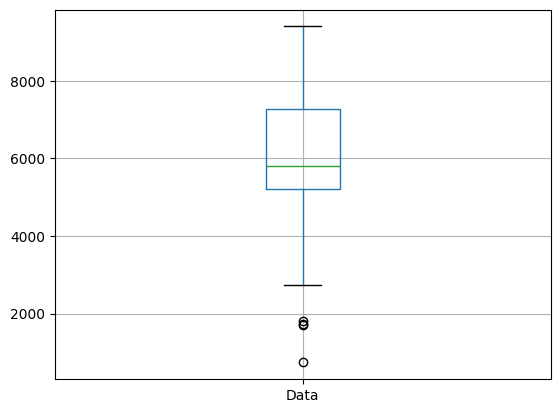

In [29]:
boxplot_train = df_train['Data'].explode().value_counts().reset_index().boxplot('Data', return_type='dict')
boxplot_train;

Получим граничные значения

In [30]:
[item.get_ydata()[1] for item in boxplot_train['whiskers']] 

[2741.0, 9402.0]

*Значения, которые не соответствуют диапазону удалим*

Общая концепция: 
1. Избавиться от выбросов
2. Определить количество значений у каждого id, построить ящик с усами, оставить только ниболее большое количество значений или то количество значений, соответствующее выборке с предсказаниями.
3. Обучить модель на данных
4. Предсказать значения для нескольких случаев(10)

In [31]:
first_info(submission_baseline_2)

,Predicted
Id,
0,[6011 4814 6010 4829 5499 5541 5411 6011 6010 ...
1,[6011 6010 5411 6011 6010 4814 5411 4829 5499 ...
2,[6011 6010 5499 4814 5411 5814 4829 5812 6011 ...
3,[6011 4814 5964 5411 4829 5912 6010 6012 5814 ...
4,[4814 6011 6011 6010 4814 5411 4829 5499 5541 ...


<class 'pandas.core.frame.DataFrame'>
Index: 7033 entries, 0 to 7032
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Predicted  7033 non-null   object
dtypes: object(1)
memory usage: 367.9+ KB


None

## fgfg

In [32]:
def str_info(num):
    print(len(df_train.loc[num, 'Data']))
    print(len(df_test.loc[num, 'Data']))
    print(len(submission_baseline_2.loc[num, "Predicted"][1:-1].split(' ')))

str_info(0)

216
224
17


In [33]:
# for i in range(5):
#     print(i+1)
#     str_info(i)
#     print()

In [34]:
submission_baseline_2.columns

Index(['Predicted'], dtype='object')